In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.integrate import solve_ivp
import sys
import os

In [3]:
#parameters in cgs units
m = 9.1e-27
e = 5.e-10
qbym = -e/m #electrons
c = 3.e10

In [4]:
#fields same as in Fig. 1 of Qin+ paper https://ui.adsabs.harvard.edu/abs/2013PhPl...20h4503Q/abstract
def cal_E_par(x): 
    return 0.0

def cal_E_perp(x):
    return 0.01*np.array([x[0],x[1]])/(x[0]*x[0]+x[1]*x[1])**1.5

def cal_B(x):
    return (x[0]*x[0]+x[1]*x[1])**0.5

In [5]:
def fun_pp(t, y, B, qbym, c):
    rhs_pp = 0.0*y
    rhs_pp[0] = y[3]
    rhs_pp[1] = y[4]
    rhs_pp[2] = y[5]
    E_perp = cal_E_perp(y[:3])
    E_par = cal_E_par(y[:3])
    B = cal_B(y[:3])
    rhs_pp[3] = qbym*(E_perp[0] + y[4]*B/c)
    rhs_pp[4] = qbym*(E_perp[1] - y[3]*B/c)
    rhs_pp[5] = qbym*E_par
    return rhs_pp

In [6]:
#initial conditions not explicitly stated in the paper; following arrived from a lot guessing; drift formulae are valid in asymptotic limit only
xi, yi, zi = 5, 0, 0
E_perp = np.sqrt(np.sum(cal_E_perp([xi, yi, zi])**2)) #magnitude of Eperp
B = cal_B([xi, yi, zi])
w_c = e*B/(m*c)
v_EB_D = c*E_perp/B #magnitude of ExB drift
v_perp = np.abs(qbym*E_perp*0.25*2*np.pi/w_c) #not the true value, just an estimate! particle accelerates for T_cyc/4
v_mugradB_D = 0.5*v_perp*v_perp/(w_c*np.sqrt(xi*xi+yi*yi+zi*zi))
print(v_perp/w_c, v_EB_D/c, v_mugradB_D/c, v_perp/c)
print(2.*np.pi/w_c, 2.*np.pi*np.sqrt(xi*xi+yi*yi+zi*zi)/v_EB_D)
n_dump = 100000
vxi, vyi, vzi = 0, 0, 0

0.41167430132640653 8e-05 5.173251842874999e-06 0.00012566370614359174
6.861238355440109e-07 1.308996938995747e-05


In [7]:
y0 = np.array([xi, yi, zi, vxi, vyi, vzi])
tend = 5000*2.0*np.pi/w_c

In [8]:
#RK4 update
sol = solve_ivp(fun_pp, [0,tend], y0, t_eval = np.linspace(0,tend,n_dump+1), args = (B, qbym, c), method = 'RK45')

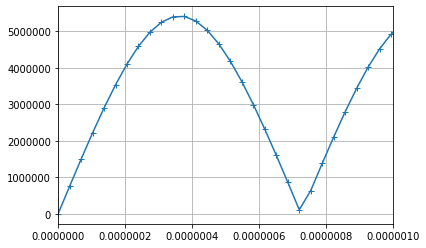

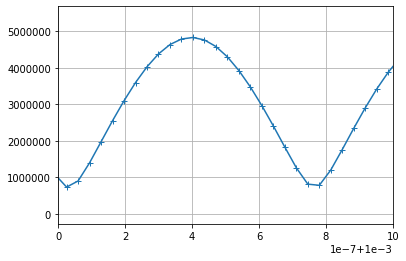

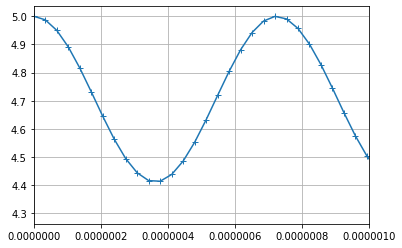

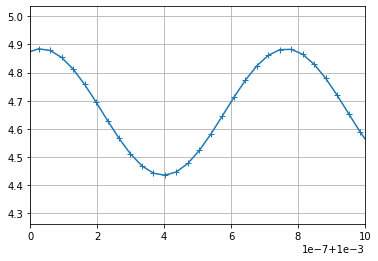

In [11]:
plt.plot(sol.t, np.sqrt(sol.y[3,:]**2+sol.y[4,:]**2), '-+')
plt.xlim([0.0,0.0+1e-6])
plt.grid()
plt.figure()
plt.plot(sol.t, np.sqrt(sol.y[3,:]**2+sol.y[4,:]**2), '-+')
plt.xlim([0.001,0.001+1e-6])
plt.grid()
plt.figure()
plt.plot(sol.t, np.sqrt(sol.y[0,:]**2+sol.y[1,:]**2), '-+')
plt.xlim([0.0,0.0+1e-6])
plt.grid()
plt.figure()
plt.plot(sol.t, np.sqrt(sol.y[0,:]**2+sol.y[1,:]**2), '-+')
plt.xlim([0.001,0.001+1e-6])
plt.grid()

915750.9157509158 300000000.0


(-5.492270769703549, 5.499631941414455, -5.487915193731511, 5.494898728119188)

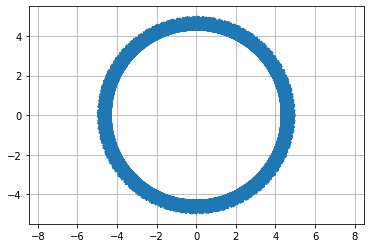

In [10]:
plt.plot(sol.y[0,:], sol.y[1,:])
#plt.axis('equal')
plt.grid()
print(0.1*w_c, 0.01*c)
plt.axis('equal')
#plt.xlim([3,5])
plt.figure()

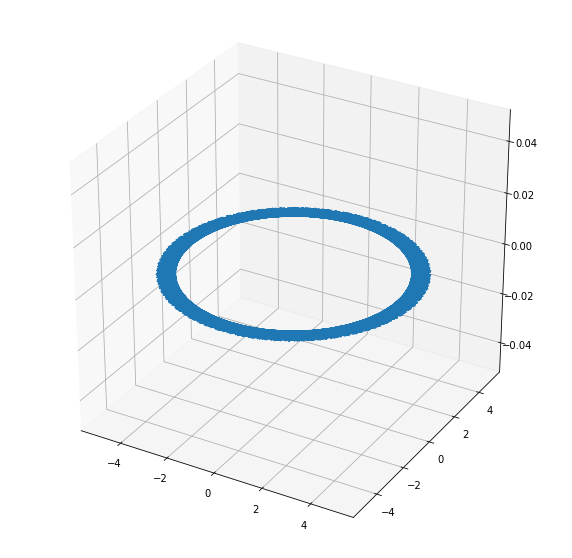

In [10]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
#ax.plot3D(sol.y[0,:]-c*.01*sol.t,sol.y[1,:],sol.y[2,:])
ax.plot3D(sol.y[0,:], sol.y[1,:], sol.y[2,:])
plt.show()